<a href="https://colab.research.google.com/github/DL-ECE/tp2-deeplearningonimages-EliasAras/blob/master/convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP-2 Deep Learning on Images

## Clothes images classification using Fashion-MNIST dataset

In this notebook you will train your second and even third neural network. 

Feel free to look back at the Lecture-2 slides to complete the cells below.



All the dependencies are installed. Below we import them and will be using them in all our notebooks.
Please feel free to look arround and look at their API.
The student should be limited to these imports to complete this work.


In [2]:
# Import the different module we will need in this notebook
import os

# To read and compute on Images: imageio [imageio doc](https://imageio.readthedocs.io/en/stable/)
# To create some plot and figures: matplolib [matplotlib doc](https://matplotlib.org/)
# To do computation on matrix and vectors: numpy [numpy doc](https://numpy.org/)
import imageio
import matplotlib.pyplot as plt
import numpy as np

# To do computation on matrix and vectors and automatic differenciation: pytorch [torch doc](https://pytorch.org/docs/stable/index.html)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

# To do some computation on images with pytorch direclty on the GPU [torchvision doc](https://pytorch.org/vision)
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
import random
import tqdm.notebook as tq

# To get the same data as TP1 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# enable tpu computation
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [3]:
# In order to have some reproducable results and easier debugging 
# we fix the seed of random.
random.seed(1342)
np.random.seed(1342)
torch.manual_seed(1342)
torch.cuda.manual_seed_all(1342)

import builtins as __builtin__
def print(*args, **kwargs):
    """My custom print() function."""
    return __builtin__.print(*args, **kwargs, end='\n\n')

## Refresh on numpy and images

In [4]:
# Let's do again basics of numpy 
mat_numpy = np.arange(15).reshape(3, 5)
print(mat_numpy) # Create a vector from 0 to 14 and reshape it into a Matrix 3X5

print(mat_numpy.shape) # Return the size of the matrix (3, 5)

print(mat_numpy[0]) # Return the first row of the matrix 

print(mat_numpy[0,3]) # Return first row and 4th column  element 

# Also interesting with higher dimension 
# Below can be though of 2 3X4 matrix 
tensor = np.zeros((2,3,4))   # Create an tensor of shape [2,2,2] of all zeros
print(tensor)                # Prints [[[0. 0. 0. 0.]
                             #          [0. 0. 0. 0.]
                             #          [0. 0. 0. 0.]]
                             #        [[0. 0. 0. 0.]
                             #         [0. 0. 0. 0.]
                             #         [0. 0. 0. 0.]]]

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]

(3, 5)

[0 1 2 3 4]

3

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]



Now it's your turn create a function that return a tensor of shape 
n_rowsxn_columsxn_channels that contains a default value every where

In [5]:
def build_image_like_tensor(n_rows:int, n_colums: int, n_channels:int, default_value: int)-> np.ndarray:
  """Create a tensor of 3 dimension. 
     It should have a shape similar to (n_rows, n_colums, n_channels)
     It should be containing the default value set by default_value
  """
  # YOUR CODE HERE
  return default_value*np.ones((n_rows, n_colums, n_channels))

In [6]:
# Create 3 different tensors with the above function containing different value between [0,255]
# Uncomment the 3 line below and complete with your answer 

rows = 320
colums = 250
channels = 3

white_like = build_image_like_tensor( rows, colums, channels, 255/255)
gray_like = build_image_like_tensor( rows, colums, channels, 127/255)
black_like = build_image_like_tensor( rows, colums, channels, 0/255)


In [7]:
# Each of the tensor that you have created can be seen as an image. Use here is the way to display it using matplotlib imshow:
def plot_one_tensor(image_tensor: np.array):
    """Function to plot the image tensor"""
    plt.imshow(image_tensor, cmap='gray')

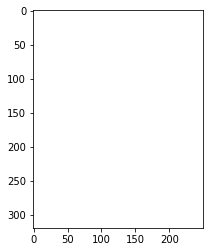

In [8]:
plot_one_tensor(white_like)

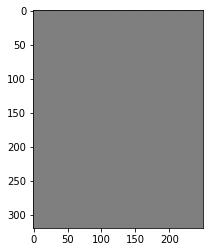

In [9]:
plot_one_tensor(gray_like)

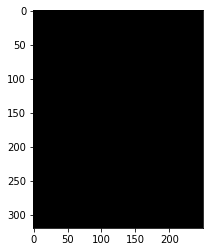

In [10]:
plot_one_tensor(black_like)

We saw that an digital image is the combination of a 3 channel tensor RGB. 
Each channel represent respectively the R red componant, G greed componant, B blue componant. 

In [11]:
# Create again 3 image tensors with your function
# Then change them to be representing a red, a green, a blue image
# Uncomment the 3 line below and complete with your answer 

rows = 320
colums = 250
channels = 3
power = 255/255

red_like = build_image_like_tensor(rows, colums, channels, [[[power, 0, 0]]])
#red_like = build_image_like_tensor(rows, colums, channels, 0)
#red_like[:,:,0]=1
#red_like[50:200:,:,0]=1
green_like = build_image_like_tensor(rows, colums, channels, [[[0, power, 0]]])
blue_like = build_image_like_tensor(rows, colums, channels, [[[0, 0, power]]])
 

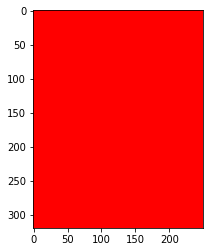

In [12]:
plot_one_tensor(red_like)

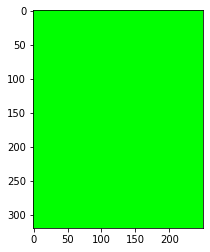

In [13]:
plot_one_tensor(green_like)

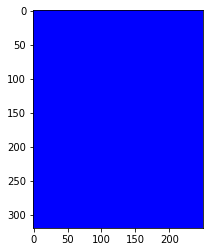

In [14]:
plot_one_tensor(blue_like)

## What Pytorch can do

*   Similar functions to Numpy on GPU
*   Calculate automatically gradient on the neural network
*   Some neural networks layers are already coded : dense, convolution, pooling, etc
*   Calculate automatically the weights update
*   Provide optimizer to compute gradient descent 



In [15]:
mat_torch = torch.arange(15).reshape(3,5)

print(mat_torch) # Create a vector from 0 to 14 and reshape it into a Matrix 3X5
print(mat_torch.shape) # Return the size of the matrix (3, 5)
print(mat_torch[0]) # Return the first row of the matrix 
print(mat_torch[0,3]) # Return first row and 4th column element 
# This was easy but everything was on the CPU so it's the same as Numpy 
# To do computation on the GPU (graphic card calculation can be 50x faster)

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

torch.Size([3, 5])

tensor([0, 1, 2, 3, 4])

tensor(3)



In [16]:
# What is the GPU on this machine ? 
# !nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
mat_torch = torch.arange(15, device=device).reshape(3,5)
print(mat_torch) # Create a vector from 0 to 14 and reshape it into a Matrix 3X5
print(mat_torch.shape) # Return the size of the matrix (3, 5)
print(mat_torch[0]) # Return the first row of the matrix 
print(mat_torch[0,3]) # Return first row and 4th column element 

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]], device='cuda:0')

torch.Size([3, 5])

tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor(3, device='cuda:0')



Let's say we want a faster sigmoid and softmax. 
We can use the same function from TP-1

In [18]:
def normalize_tensor(input_tensor: torch.Tensor) -> torch.Tensor:
    """Apply a normalization to the tensor"""
    # YOUR CODE HERE
    return input_tensor/255

def sigmoid(input_tensor: torch.Tensor) -> torch.Tensor:
    """Apply a sigmoid to the input Tensor"""
    # YOUR CODE HERE
    fct = torch.nn.Sigmoid()
    return fct(input_tensor)

def softmax(input_tensor: torch.Tensor)-> torch.Tensor:
    """Apply a softmax to the input tensor"""
    # YOUR CODE HERE 
    fct = torch.nn.Softmax(dim=1)
    return fct(input_tensor)

def target_to_one_hot(targets: torch.Tensor, num_classes=10) -> torch.Tensor:
    """Create the one hot representation of the target""" 
    # YOUR CODE HERE 
    one_hot_matrix = torch.zeros([targets.shape[0], num_classes])
    for indice in range(targets.shape[0]):
      one_hot_matrix[indice][int(targets[indice])] = 1
    ###
    return one_hot_matrix

In [19]:
# However as mention above pytorch already has some built-ins function 

# sigmoid function [sigmoid doc](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html?highlight=sigmoid#torch.nn.Sigmoid)
# softmax function [softmax doc](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax) 


In [20]:
mat_torch = torch.arange(15, dtype=torch.float64, device=device).reshape(3,5)
# Uncomment the line bellow to check if your implementation is correct

assert torch.allclose(sigmoid(mat_torch), torch.sigmoid(mat_torch))
print(sigmoid(mat_torch))
print(torch.sigmoid(mat_torch))

# assert torch.allclose(softmax(mat_torch))
assert torch.allclose(softmax(mat_torch),torch.softmax(mat_torch, dim=1))
print(softmax(mat_torch))
print(torch.softmax(mat_torch, dim=1))

tensor([[0.5000, 0.7311, 0.8808, 0.9526, 0.9820],
        [0.9933, 0.9975, 0.9991, 0.9997, 0.9999],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], device='cuda:0',
       dtype=torch.float64)

tensor([[0.5000, 0.7311, 0.8808, 0.9526, 0.9820],
        [0.9933, 0.9975, 0.9991, 0.9997, 0.9999],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], device='cuda:0',
       dtype=torch.float64)

tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.0117, 0.0317, 0.0861, 0.2341, 0.6364]], device='cuda:0',
       dtype=torch.float64)

tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.0117, 0.0317, 0.0861, 0.2341, 0.6364]], device='cuda:0',
       dtype=torch.float64)



## Transforming our Neural network from TP1

In [21]:
if __name__ == "__main__":
    # Downloading again the same MNIST dataset 

    mnist_data, mnist_target = fetch_openml('mnist_784', version=1, return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_target, test_size=0.33, random_state=1342)
    # Change the input data to be normalize and target data to be correctly encoded 

    X_train = normalize_tensor(X_train)
    X_train = torch.from_numpy(X_train.astype(np.float32))

    X_test = normalize_tensor(X_test)
    X_test = torch.from_numpy(X_test.astype(np.float32))

    y_train = target_to_one_hot(y_train)
    #y_train = torch.from_numpy(y_train).long()

    y_test = target_to_one_hot(y_test)
    #y_test = torch.from_numpy(y_test).long()

Your remember the famous `class FFNN` from **TP1** ?? 

Here we will create the same version but with pytorch and we will see the power of this framework. 

Auto calculation of the backward pass and auto update of the weights 🎉 

In pytorch a dense layer similar to our `Class Layer` is a called **Linear Layer**

[linear layer documentation] -> https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

In [22]:
class FFNN(nn.Module):
    def __init__(self, config, device, minibatch_size=100, learning_rate=0.01, momentum=0):
        super().__init__()
        self.layers = []
        self.nlayers = len(config)
        self.minibatch_size = minibatch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.device = device 

        # We use the built-in activation functions
        # TODO: Maybe try with another activation function !
         
        # self.activation = torch.nn.Sigmoid()
        self.activation = torch.nn.ReLU()


        self.last_activation = torch.nn.Softmax(dim=1)

        # First difference we don't need a special Input layer 😃
        # Second one we can declare them more easely
        for i in range(1,len(config)):
          layer = nn.Linear(config[i-1], config[i])
          self.layers.append(layer)
          self.layers.append(self.activation)

        self.layers[-1]= self.last_activation
        self.model = nn.Sequential(*self.layers)

        # We use the built-in function to compute the loss
        # TODO: Maybe try with another loss function ! 

        # self.loss_function = torch.nn.MSELoss()
        self.loss_function = torch.nn.CrossEntropyLoss()

        # We use the built-in function to update the model weights
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.momentum)

    # Here we see the power of Pytorch
    # The forward is just giving the input to our model
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
      y_pred = self.model(input_tensor)
      return y_pred

    def compute_loss(self, y_pred: torch.Tensor, y_true) -> torch.Tensor:
        y_true = torch.argmax(y_true, dim=1)
        loss = self.loss_function(y_pred.float(), y_true)
        # looking at what the loss looks like
        # print(loss)
        return loss

    # Even more powerful no need to code all the derivative of the different function
    def backward_pass(self, loss: torch.tensor) -> None:
        loss.backward()
        return

    # The previoulsy hard function to update the weight become also easy
    def update_all_weights(self):
      # Using pytorch
      self.optimizer.step()


    def get_error(self, y_pred, y_true) -> float:
      y_pred = torch.argmax(y_pred, dim=1)
      y_true = torch.argmax(y_true, dim=1)
      return (y_pred == y_true).float().mean()

    def get_test_error(self, X_test, y_test) -> float:
      nbatch = X_test.shape[0]
      error_sum = 0.0
      for i in range(0, nbatch):
          X_batch = X_test[i,:,:].reshape(self.minibatch_size, -1)
          y_batch = y_test[i,:,:].reshape(self.minibatch_size, -1)
          y_pred = self.model(X_batch)
          error_sum += self.get_error(y_pred, y_batch)
      return error_sum / nbatch

    def train(self, n_epochs: int, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor):
      X_train = X_train.reshape(-1, self.minibatch_size, 784).to(self.device)
      y_train = y_train.reshape(-1, self.minibatch_size, 10).to(self.device)

      X_test = X_test.reshape(-1, self.minibatch_size, 784).to(self.device)
      y_test = y_test.reshape(-1, self.minibatch_size, 10).to(self.device)

      
      self.model = self.model.to(device)
      nbatch = X_train.shape[0]
      error_test = 0.0
      for epoch in range(n_epochs): 
        error_sum_train = 0.0
        for i in range(0, nbatch):
          X_batch = X_train[i,:, :]
          y_batch = y_train[i,:, :]
          # In order to have the correct derivative we remove the one from before 
          self.optimizer.zero_grad()
          # Then we do a pass forward 
          y_pred = self.model(X_batch)
          # We compute the loss 
          loss = self.compute_loss(y_pred, y_batch)
          # And calculate the backward pass
          self.backward_pass(loss=loss)
          # To finally update the weights using stochastic gradient descent 
          self.update_all_weights()
          error_sum_train += self.get_error(y_pred, y_batch)
        error_test = self.get_test_error(X_test, y_test)
        
        print(f"Training Loss: {loss:.3f}, Training accuracy: {error_sum_train / nbatch:.3f}, Test accuracy: {error_test:.3f}")
      return loss, error_test

In [23]:
if __name__ == "__main__":
    minibatch_size = 28
    nepoch = 50
    learning_rate = 0.1
    ffnn = FFNN(config=[784, 256, 128, 10], device=device, minibatch_size=minibatch_size, learning_rate=learning_rate)
    print(ffnn)
    loss, err = ffnn.train(nepoch, X_train, y_train, X_test, y_test)

FFNN(
  (activation): ReLU()
  (last_activation): Softmax(dim=1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
  (loss_function): CrossEntropyLoss()
)

Training Loss: 1.530, Training accuracy: 0.652, Test accuracy: 0.835

Training Loss: 1.504, Training accuracy: 0.842, Test accuracy: 0.849

Training Loss: 1.501, Training accuracy: 0.851, Test accuracy: 0.857

Training Loss: 1.466, Training accuracy: 0.864, Test accuracy: 0.913

Training Loss: 1.466, Training accuracy: 0.927, Test accuracy: 0.932

Training Loss: 1.466, Training accuracy: 0.940, Test accuracy: 0.943

Training Loss: 1.468, Training accuracy: 0.949, Test accuracy: 0.950

Training Loss: 1.466, Training accuracy: 0.955, Test accuracy: 0.952

Training Loss: 1.465, Training accuracy: 0.961, Test accuracy: 0.9

In pytorch a very convinient way to load data in batch si to use the data loader. 

Let's update the class to use it, we are also going to use dataset available in pytorch vision.

In [24]:
class FFNNModel(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(784, 256)
        self.l2 = torch.nn.Linear(256, 128)
        self.l3 = torch.nn.Linear(128, classes)
        self.activation = torch.nn.ReLU()
        self.last_activation = torch.nn.Softmax(dim=1)

    def forward(self, input):
        input = input.reshape(input.size(0), -1)
        x = self.l1(input)
        x = self.activation(x)
        x = self.l2(x)
        x = self.activation(x)
        x = self.l3(x)
        y = self.last_activation(x)
        return y

def train_one_epoch(model, device, data_loader, optimizer):
    train_loss = 0
    correct = 0
    for num, (data, target) in tq.tqdm(enumerate(data_loader), total=len(data_loader.dataset)/data_loader.batch_size):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        prediction = output.argmax(dim=1)
        correct += torch.sum(prediction.eq(target)).item()

    result = {'loss': train_loss / len(data_loader.dataset),
              'accuracy': correct / len(data_loader.dataset)
              }
    return result   
 
def evaluation(model, device, data_loader):
    eval_loss = 0
    correct = 0

    for num, (data, target) in tq.tqdm(enumerate(data_loader), total=len(data_loader.dataset)/data_loader.batch_size):
        data, target = data.to(device), target.to(device)
        output = model(data)
        eval_loss += F.cross_entropy(output, target).item()
        prediction = output.argmax(dim=1)
        correct += torch.sum(prediction.eq(target)).item()
    result = {'loss': eval_loss / len(data_loader.dataset),
              'accuracy': correct / len(data_loader.dataset)
              }
    return result

In [25]:

if __name__ == "__main__":
    
    # Network Hyperparameters 
    minibatch_size = 28
    nepoch = 10
    learning_rate = 0.1
    momentum = 0 
    model = FFNNModel()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Retrieve the data with the pytorch dataloader 
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
    mnist_train = DataLoader(mnist_train, batch_size=32, num_workers=4, pin_memory=True)
    mnist_val = MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())
    mnist_val = DataLoader(mnist_val, batch_size=32, num_workers=4,  pin_memory=True)

    # Train for an number of epoch 
    for epoch in range(nepoch):
      print(f"training Epoch: {epoch}")
      if epoch > 0:
        train_result = train_one_epoch(model, device, mnist_train, optimizer)
        print(f"Result Training dataset {train_result}")

      eval_result = evaluation(model, device, mnist_val)
      print(f"Result Test dataset {eval_result}")



Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!
training Epoch: 0






/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Result Test dataset {'loss': 0.07207407481670379, 'accuracy': 0.1073}

training Epoch: 1




Result Training dataset {'loss': 0.059505303355058034, 'accuracy': 0.6259}




Result Test dataset {'loss': 0.052068591248989105, 'accuracy': 0.8178}

training Epoch: 2




Result Training dataset {'loss': 0.05104524713953336, 'accuracy': 0.8353833333333334}




Result Test dataset {'loss': 0.05078759477138519, 'accuracy': 0.8432}

training Epoch: 3




Result Training dataset {'loss': 0.05006516743103663, 'accuracy': 0.8639}




Result Test dataset {'loss': 0.04869766182899475, 'accuracy': 0.9117}

training Epoch: 4




Result Training dataset {'loss': 0.04812807259360949, 'accuracy': 0.9279}




Result Test dataset {'loss': 0.047966019797325135, 'accuracy': 0.9332}

training Epoch: 5




Result Training dataset {'loss': 0.047619749148686726, 'accuracy': 0.94235}




Result Test dataset {'loss': 0.047602860963344575, 'accuracy': 0.9438}

training Epoch: 6




Result Training dataset {'loss': 0.04732808235883713, 'accuracy': 0.9509333333333333}




Result Test dataset {'loss': 0.0473987962603569, 'accuracy': 0.9491}

training Epoch: 7




Result Training dataset {'loss': 0.04710458229581515, 'accuracy': 0.9575}




Result Test dataset {'loss': 0.04725181463956833, 'accuracy': 0.954}

training Epoch: 8




Result Training dataset {'loss': 0.04692169992129008, 'accuracy': 0.9636666666666667}




Result Test dataset {'loss': 0.04707754421234131, 'accuracy': 0.9586}

training Epoch: 9




Result Training dataset {'loss': 0.04677304334044456, 'accuracy': 0.9677333333333333}




Result Test dataset {'loss': 0.047044487810134886, 'accuracy': 0.96}



# Part 1: What is a convolution ?




In this section you will implement 2D convolution operation using:

Starting with a simple example and manual computation like in Lecture 2

1) Introduction: manual computation

- you have as input an image of 5x5 pixels

$I = \begin{bmatrix}I_{1, 1} & ... & I_{1, 5} \\ \vdots & \ddots & \vdots \\ I_{5, 1}& ... & I_{5,5}\end{bmatrix}$

Your task is to compute the result of a convolution operation between this image and a 3x3 kernel

$ K = \begin{bmatrix}a & b & c \\d & e & f \\ g& h& i\end{bmatrix}$

We are considering padding with 0 and using the SAME convolution. 
Meaning that arround the I matrix consider there is the value 0.

Tips: the result of the convolution is a 5x5 matrix

In [26]:
I = np.array([[252,  49, 113,  11, 137],
                [ 18, 237, 163, 119,  53],
                [ 90,  89, 178,  75, 247],
                [209, 216,  48, 135, 232],
                [229, 53, 107, 106, 222]])
print(f"I =")
print(I)

I =

[[252  49 113  11 137]
 [ 18 237 163 119  53]
 [ 90  89 178  75 247]
 [209 216  48 135 232]
 [229  53 107 106 222]]



In [27]:
K_0 = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
print(f"K_0 =")
print(K_0)

K_1 = np.array([[1, 1, 1], [0, 5, 0], [-1, -1, -1]])
print(f"K_1 =")
print(K_1)


K_0 =

[[0 1 0]
 [0 0 0]
 [0 0 0]]

K_1 =

[[ 1  1  1]
 [ 0  5  0]
 [-1 -1 -1]]



What is the result of convolution of $ I_0 \ast K_0 $


In [28]:
# put your answer here
R_0 = np.array([[0,0,0,0,0],[252,49,113,11,137],[18,237,163,119,53],[90,89,178,75,247],[209,216,48,135,232]])

What is the result of convolution of $ I_0 \ast K_1 $


In [29]:
# put your answer here
R_1 = np.array([[1005, -173, 46, -280, 513], [212, 1242, 646, 356, 91], [280, 390, 1010, 295, 1040], [942, 1048, 316, 740, 1154], [1570, 738, 934, 945, 1477]])

## 2) Computation using __numpy__

Now using the numpy implement the convolution operation.


In [30]:
def convolution_forward_numpy(image, kernel):
    # YOUR CODE HERE 
    image_c = np.c_[np.zeros((image.shape[0], 1)), image, np.zeros((image.shape[0], 1))]
    image_c = np.r_[np.zeros((1, image_c.shape[1])), image_c, np.zeros((1, image_c.shape[1]))]

    out = np.zeros(image.shape)

    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            out[x, y] = (kernel * image_c[x:(x+3), y:(y+3)]).sum()
    return out
      

Test your implementation on the two previous example and compare the results to the result manually computed.

In [31]:
assert np.array_equal(convolution_forward_numpy(I, K_0), R_0)
assert np.array_equal(convolution_forward_numpy(I, K_1), R_1)

Display the result image of the convolution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


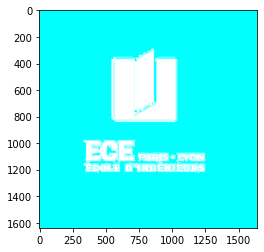

In [32]:
# Load image from url, you can use an other image if you want
image_url = "https://upload.wikimedia.org/wikipedia/commons/4/4f/ECE_Paris_Lyon.jpg"
image = imageio.imread(image_url)


# simple function to display image
def display_image(img):
    plt.imshow(img)

# display the image
display_image(image[:,:,0])


# Do the convolution operation and display the resulting image

# YOUR CODE HERE
output_image = np.zeros((image.shape))
for i in range(image.shape[2]):
    output_image[:,:,i] = convolution_forward_numpy(image[:,:,i], K_1)
display_image(output_image)

## 3) Computation using __pytorch__

Now let's use pytorch convolution layer to do the forward pass. Use the documentation available at: https://pytorch.org/docs/stable/nn.html

In [33]:
def convolution_forward_torch(image, kernel):
    # YOUR CODE HERE 

    #On reshape nos donnees
    image_c = image.reshape(1, 1, image.shape[0], image.shape[1])
    #On convertit le format et on cast en float sinon on a une erreur de type long
    image_c = torch.from_numpy(image_c).float()

    #On cree notre kernel avec pytroch et nos parametre
    layer = nn.Conv2d(1, 1, kernel_size=(kernel.shape), stride=1, padding=1)

    #On associe les poids de notre kernel a notre layer pytorch
    layer.weight[:] = torch.from_numpy(kernel).float()

    #On convolue
    out = layer(image_c)

    return out.detach().numpy()

In pytorch you can also access other layer like convolution2D, pooling layers, for example in the following cell use the __torch.nn.MaxPool2d__ to redduce the image size.

In [34]:
print(convolution_forward_torch(I,K_0))
print(R_0)

[[[[ -0.27456614  -0.27456614  -0.27456614  -0.27456614  -0.27456614]
   [251.72543     48.725433   112.72543     10.725434   136.72543   ]
   [ 17.725433   236.72543    162.72543    118.72543     52.725433  ]
   [ 89.72543     88.72543    177.72543     74.72543    246.72543   ]
   [208.72543    215.72543     47.725433   134.72543    231.72543   ]]]]

[[  0   0   0   0   0]
 [252  49 113  11 137]
 [ 18 237 163 119  53]
 [ 90  89 178  75 247]
 [209 216  48 135 232]]



# Part 2: Using convolution neural network to recognize digits

In this section you will implement 2D convolution neural network and train it on fashion mnist dataset

https://github.com/zalandoresearch/fashion-mnist


![Image of fashion mnist](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

##  First let's look at the data.

In [35]:
if __name__ == "__main__" :

  fmnist_train = FashionMNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
  fmnist_train = DataLoader(fmnist_train, batch_size=32, num_workers=4, pin_memory=True)
  fmnist_val = FashionMNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())
  fmnist_val = DataLoader(fmnist_val, batch_size=32, num_workers=4,  pin_memory=True)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


Display the 10 image from train set and 10 images from validation set, print their ground truth

In [36]:
def categorie_name(target):
  categorie = {0 : "T-shirt/top", 1	: "Trouser", 2 : "Pullover", 3 : "Dress", 
               4 : "Coat", 5 : "Sandal", 6 : "Shirt", 7 : "Sneaker", 8 : "Bag", 9 : "Ankle boot"}

  if target > len(categorie) or target < 0:
    return "None"
  else :
    return categorie[target]

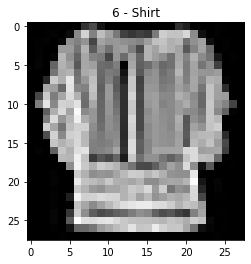

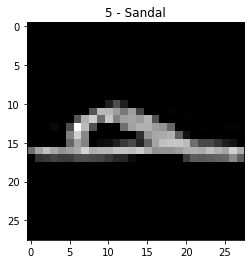

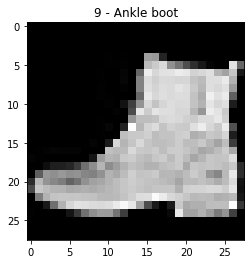

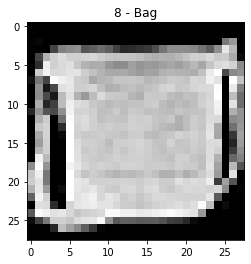

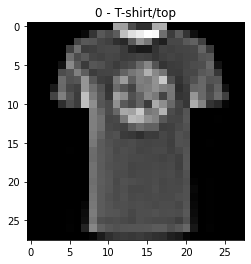

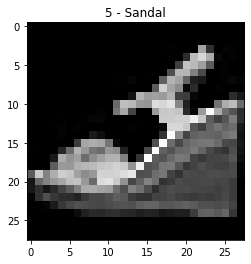

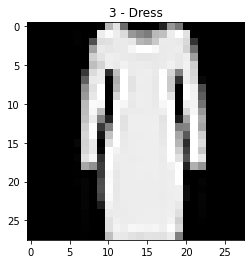

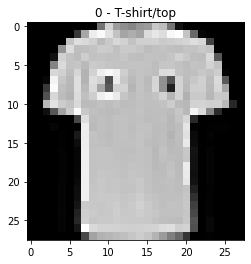

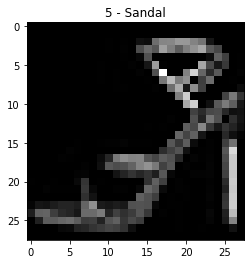

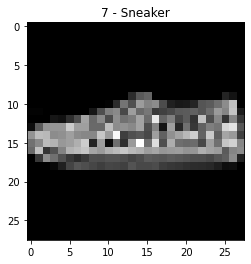

In [37]:
def display_10_images(dataset):
    # YOUR CODE HERE 
    random_indice = np.random.randint(0,len(dataset),10)
    for i in random_indice:
      image, target = dataset[i]
      plt.title(str(target) + " - " + categorie_name(target))
      plot_one_tensor(image)
      plt.show()

a = FashionMNIST(os.getcwd(), train=True, download=True)
display_10_images(a)

What is the shape of each images
How many images do we have
What are the different classes

In [38]:
def fashion_mnist_dataset_answer():
    shape = (28,28)  # replace None with the value you found
    number_of_images_in_train_set = 60000
    number_of_images_in_test_set = 10000
    number_of_classes = 10
    return {'shape': shape, 'nb_in_train_set': number_of_images_in_train_set, 'nb_in_test_set': number_of_images_in_test_set, 'number_of_classes': number_of_classes}

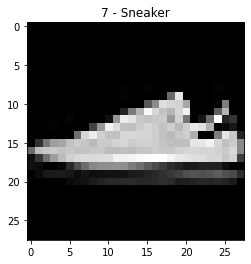

In [39]:
# Plot an image and the target 
data = FashionMNIST(os.getcwd(), train=True, download=True)
image, target = data[6]

plt.title(str(target) + " - " + categorie_name(target))
plot_one_tensor(image)

## Create a convolutional neural network

Now it's your turn to create a convolutional neural network and to train your model on the fashion mnist dataset.

Classical machine learning approach manage to get a 89% accuracy on fashion mnist, your objective is to use deep learning (and convolution neural network) to get more than 90%

You can first start with this simple convolution network and improve it by adding/modifying the layers used:

```
convolutional layer 3x3
convolutional layer 3x3
max-pooling
convolutional layer 3x3
convolutional layer 3x3
max-pooling
flatten
fully-connected layer (dense layer)
fully-connected layer (dense layer)
fully-connected layer (dense layer)
Softmax
```


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        # YOUR CODE HERE 
        self.conv1 = nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()

        self.fct1 = nn.Linear(32*7*7, 64) 
        self.fct2 = nn.Linear(64, 40)
        self.fct3 = nn.Linear(40, 10)

    def forward(self, input):
        # YOUR CODE HERE 
        #Convolution + Maxpool
        conv = self.conv1(input)
        conv = self.conv2(conv)

        conv = self.maxpool(conv)
        conv = self.conv3(conv)
        conv = self.conv4(conv)

        conv = self.maxpool(conv)

        #Flatten
        flat = conv.reshape(conv.size(0), -1)

        #Fully-Connected
        fcon = self.fct1(flat)
        fcon = self.fct2(fcon)
        fcon = self.fct3(fcon)

        y = self.relu(fcon)
        return y

def train_one_epoch(model, device, data_loader, optimizer):
    train_loss = 0
    correct = 0
    for num, (data, target) in tq.tqdm(enumerate(data_loader), total=len(data_loader.dataset)/data_loader.batch_size):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # YOUR CODE HERE 
        loss = F.cross_entropy(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        prediction = output.argmax(dim=1)
        correct += torch.sum(prediction.eq(target)).item()

    result = {'loss': train_loss / len(data_loader.dataset),
              'accuracy': correct / len(data_loader.dataset)
              }
    return result   
 
def evaluation(model, device, data_loader):
    eval_loss = 0
    correct = 0

    for num, (data, target) in tq.tqdm(enumerate(data_loader), total=len(data_loader.dataset)/data_loader.batch_size):
        data, target = data.to(device), target.to(device)
        output = model(data)
        # YOUR CODE HERE 
        eval_loss = F.cross_entropy(output, target).item()
        prediction = output.argmax(dim=1)
        correct += torch.sum(prediction.eq(target)).item()
    result = {'loss': eval_loss / len(data_loader.dataset),
              'accuracy': correct / len(data_loader.dataset)
              }
    return result
    
if __name__ == "__main__":
    
    # Network Hyperparameters 
    # YOUR CODE HERE 
    minibatch_size = 12
    nepoch = 24
    learning_rate = 0.009
    momentum = 0.9


    model = CNNModel()
    model.to(device)

    # YOUR CODE HERE 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train for an number of epoch 
    for epoch in range(nepoch):
      print(f"training Epoch: {epoch}")
      if epoch > 0:
        train_result = train_one_epoch(model, device, mnist_train, optimizer)
        print(f"Result Training dataset {train_result}")

      eval_result = evaluation(model, device, mnist_val)
      print(f"Result Test dataset {eval_result}")

## Open Analysis
Same as TP 1 please write a short description of your experiment

# BONUS 

Use some already trained CNN to segment YOUR image. 

In the cell below your can load a image to the notebook and use the given network to have the segmentation mask and plot it. 

In [ ]:
if __name__ == "__main__" :
    
    # TODO HERE: Upload an image to the notebook in the navigation bar on the left
    # `File` `Load File`and load an image to the notebook. 
    
    filename = "/content/tshirt.jpg" 
    # Loading a already trained network in pytorch 
    model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    from PIL import Image
    from torchvision import transforms

    input_image = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)